# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [46]:
#Go to the main directory
#!pip install --editable .
#!pip install pandas
# !pip install wntr
# !pip install pandapower
# !pip install sklearn

#to find requirements
#depfinder -y .

In [47]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import required packages

In [48]:
from pathlib import Path
from dreaminsg_integrated_model.src.network_recovery import *
import dreaminsg_integrated_model.src.simulation as simulation
from dreaminsg_integrated_model.src.network_sim_models.integrated_network import *

from dreaminsg_integrated_model.src.network_sim_models.interdependencies import *

from dreaminsg_integrated_model.src.optimizer import *
import dreaminsg_integrated_model.src.plots as model_plots

import random

## Create an IntegratedNetwork object

In [49]:
simple_network = IntegratedNetwork()

### Load the three infrastructure models: Water, Power and Transportation

Three different models are used:
- Water distribution network using **wntr** package
- Power systems using **pandapower** package
- Transportation network using static traffic assignment package developed by Dr. Stephen Boyles (University of Texas at Austin)

In [50]:
MAIN_DIR = Path('..')

network_dir= 'in2'
water_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/water/Example_water2.inp'
power_file = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/power/Example_power.json'
transp_folder = MAIN_DIR/f'dreaminsg_integrated_model/data/networks/{network_dir}/transportation/'

# load all infrastructure networks
simple_network.load_networks(water_file, power_file, transp_folder)

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\water\Example_water2.inp. The analysis type is set to Pressure Dependent Demand Analysis.
initial simulation duration: 60s; hydraulic time step: 60s; pattern time step: 3600s

Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\power\Example_power.json

Transportation network successfully loaded from ..\dreaminsg_integrated_model\data\networks\in2\transportation. Static traffic assignment method will be used to calculate travel times.


### Create a Networkx graph of the integrated infrastructure network.

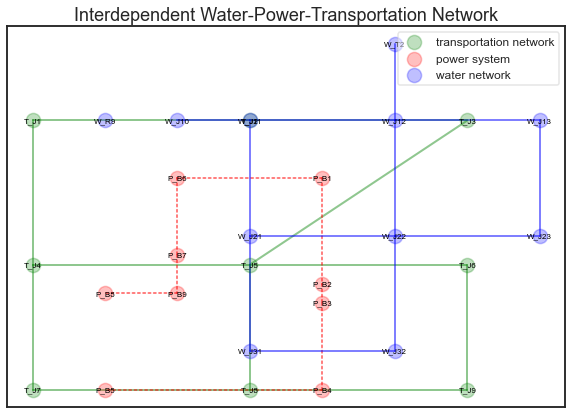

In [51]:
simple_network.generate_integrated_graph(plotting = True)

### Build interdependencies

Three types of dependencies:
- Power - Water dependencies (eg.: water pump on electric motor, generator on reservoir)
- Power - Transportation dependencies (eg.: road access to power system components for M&R)
- Water - Transportation dependencies (eg.: road access to water network components for M&R)

The dependencies are referenced using two tables in the model.
- **wp_table** for water - power dependencies
- **access_table** for transportation dependencies

In [52]:
dependency_file = MAIN_DIR/f"dreaminsg_integrated_model/data/networks/{network_dir}/dependecies.csv"
simple_network.generate_dependency_table(dependency_file = dependency_file)
simple_network.dependency_table.wp_table

,water_id,power_id,water_type,power_type
0,W_WP9,P_MP1,Pump,Motor
1,W_R9,P_G3,Reservoir,Generator


In [53]:
simple_network.dependency_table.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,P_B8,T_J4,power,Bus,125.00
1,P_B7,T_J5,power,Bus,103.08
2,P_B5,T_J7,power,Bus,100.00
3,P_B4,T_J8,power,Bus,100.00
4,P_B6,T_J2,power,Bus,180.28


### Set failed components

In [54]:
scenario_file = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/{}/{}.csv".format('test1', 'motor_failure_net1')

simple_network.set_disrupted_components(scenario_file=scenario_file)
simple_network.get_disrupted_components()

['T_L2', 'P_MP1', 'W_P21', 'W_WP9']

In [55]:
simple_network.pipe_leak_node_generator()

### Set initial crew locations

In [56]:
simple_network.set_init_crew_locs(init_power_loc='T_J8',
init_water_loc='T_J8', init_transpo_loc='T_J8')

## Simulation of interdependent effects using a test scenario
### (a) Create NetworkRecovery

In [57]:
network_recovery = NetworkRecovery(simple_network, sim_step=60)

### (b) Create a simulation object

In [58]:
sim_step = (
    simple_network.wn.options.time.hydraulic_timestep
)  # initial_sim_step which will be updated during the simulation
bf_simulation = simulation.NetworkSimulation(network_recovery, sim_step)

### (c) Generation of random repair order

In [59]:
#Generate a random repair order
repair_order = network_recovery.network.get_disrupted_components()
random.shuffle(repair_order)
print('Current repair order is {}'.format(repair_order))

Current repair order is ['W_WP9', 'P_MP1', 'W_P21', 'T_L2']


### (d) Generation of event tables

In [60]:
bf_simulation.network_recovery.schedule_recovery(repair_order)
network_recovery.get_event_table().head()

Iteration 1: gap 4642.279088: time 0.000997
Iteration 2: gap 0.000936: time 0.005491
Iteration 3: gap 0.000000: time 0.008988
Iteration 1: gap 0.354227: time 0.000997
Iteration 2: gap 0.000936: time 0.004987
Iteration 3: gap 0.000000: time 0.009974


,time_stamp,components,perf_level,component_state
0,0,T_L2,100,Functional
1,0,P_MP1,100,Functional
2,0,W_P21,100,Functional
3,0,W_WP9,100,Functional
4,6000,T_L2,50,Service Disrupted


In [61]:
bf_simulation.expand_event_table(20)
network_recovery.get_event_table().tail(5)

,time_stamp,components,perf_level,component_state
91,94260,W_P21,100,Service Restored
27,94380,P_MP1,100,Service Restored
93,94380,T_L2,100,Service Restored
94,94380,W_P21,100,Service Restored
95,94380,W_WP9,100,Service Restored


In [62]:
# network_recovery.get_event_table().time_stamp.unique()

### (e) Simulation of interdependent effects

In [63]:
resilience_metrics = bf_simulation.simulate_interdependent_effects(
    bf_simulation.network_recovery)

water_auc = metrics.auc(resilience_metrics.time_tracker, resilience_metrics.water_consump_tracker) / max(
        resilience_metrics.time_tracker)
power_auc = metrics.auc(resilience_metrics.time_tracker, resilience_metrics.power_consump_tracker) / max(
    resilience_metrics.time_tracker)


Simulating network conditions at 60 s

Simulating network conditions at 6060 s

Simulating network conditions at 6600 s

Simulating network conditions at 7260 s

Simulating network conditions at 7740 s

Simulating network conditions at 8460 s

Simulating network conditions at 9300 s

Simulating network conditions at 9480 s

Simulating network conditions at 9660 s

Simulating network conditions at 18900 s

Simulating network conditions at 28320 s

Simulating network conditions at 37740 s

Simulating network conditions at 45180 s

Simulating network conditions at 45300 s

Simulating network conditions at 45420 s

Simulating network conditions at 45540 s

Simulating network conditions at 47160 s

Simulating network conditions at 56580 s

Simulating network conditions at 66000 s

Simulating network conditions at 75420 s

Simulating network conditions at 84840 s

Simulating network conditions at 88620 s

Simulating network conditions at 88740 s

Simulating network conditions at 88860 s

Si

### (f) Calculation of resilience metric

In [64]:
auc = 0.5 * water_auc + 0.5 * power_auc
print(
    "Water AUC: ",
    round(water_auc, 3),
    "\t",
    "Power AUC: ",
    round(power_auc, 3),
    "\t",
    "Weighted AUC: ",
    round(auc, 3),
)

Water AUC:  0.153 	 Power AUC:  0.944 	 Weighted AUC:  0.548


### Plot the direct and interdependent effects

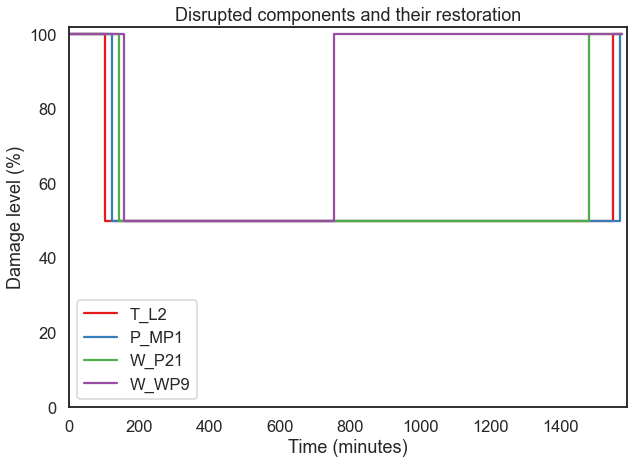

In [65]:
#Plotting repair curves
model_plots.plot_repair_curves(network_recovery, scatter = False)

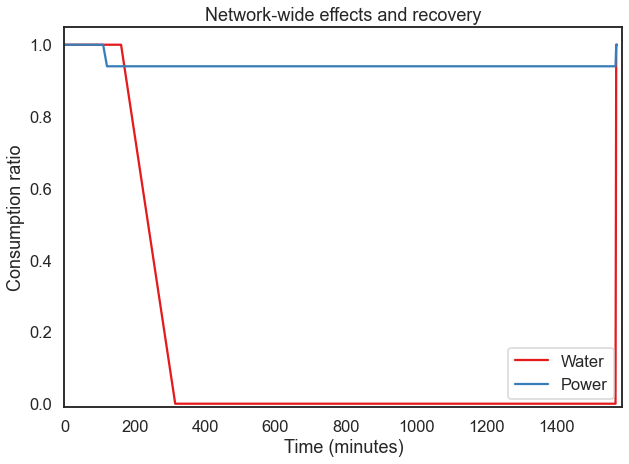

In [66]:
time_tracker, power_consump_tracker, water_consump_tracker = (
    resilience_metrics.time_tracker, resilience_metrics.power_consump_tracker, resilience_metrics.water_consump_tracker)
model_plots.plot_interdependent_effects(
        power_consump_tracker,
        water_consump_tracker,
        time_tracker,
        scatter=False,
    )

In [67]:
# time_tracker, power_consump_tracker, water_consump_tracker = bf_optimizer.get_trackers()

# location = MAIN_DIR/"dreaminsg_integrated_model/data/disruptive_scenarios/test1"
# bf_simulation.write_results(
#     time_tracker, power_consump_tracker, water_consump_tracker, location, plotting=False
# )